In [ ]:
## get the full path name of the train_images and test_images 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import skimage
from skimage.io import imread
from skimage.transform import resize

In [5]:
import tensorflow as tf

In [33]:
def load_image_files(container_path, dimension=(224, 224)):
    """
    Load image files with categories as subfolder names 
    which performs like scikit-learn sample dataset
    
    Parameters
    ----------
    container_path : string or unicode
        Path to the main folder holding one subfolder per category
    dimension : tuple
        size to which image are adjusted to
        
    Returns
    -------
    Bunch
    """
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    images = []
    flat_data = []
    target = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            
            img = skimage.io.imread(file) ## need to add in plugin for reading png images.
            #img = img[:,:,:3]
            img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
            #flat_data.append(img_resized.flatten()) 
            flat_data.append(img_resized)
            images.append(img_resized)
            target.append(i)
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)

    return Bunch(data=flat_data,
                 target=target,
                 target_names=categories,
                 images=images,
                 DESCR=descr)

In [ ]:
train_data = load_image_files("/kaggle/input/autistic-children-data-set-traintestvalidate/train")

In [ ]:
len(train_data['images'])

In [ ]:
train_data['target_names']

In [ ]:
train_data['images'][0].shape

In [ ]:
plt.figure()
plt.imshow(train_data['images'][0])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
## read in validation  data 
valid_data = load_image_files("/kaggle/input/autistic-children-data-set-traintestvalidate/valid")

In [34]:
## read in test data 
test_data = load_image_files("/kaggle/input/autistic-children-data-set-traintestvalidate/test")

In [ ]:
len(valid_data['images'])

In [18]:
len(test_data['images'])

200

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.9):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [ ]:
train_data.keys()

In [ ]:
train_data['target'].shape

In [4]:
def get_labels(prob_model, images):
    predictions = prob_model.predict(images)

    ## based on the max value of probability , predict the class.
    predicted_labels = []
    for i in range(len(predictions)):
        pred_label = np.argmax(predictions[i])
        predicted_labels.append(pred_label)
    return predicted_labels


In [6]:
# Create a list with the filepaths for training and testing
train_img_Path = "/kaggle/input/autistic-children-data-set-traintestvalidate/train"

valid_img_Path = "/kaggle/input/autistic-children-data-set-traintestvalidate/valid"

test_img_Path = "/kaggle/input/autistic-children-data-set-traintestvalidate/test"


#img_Path = '../input/resized-plant2021/img_sz_256'
print(train_img_Path)
print(valid_img_Path)
print(test_img_Path)


/kaggle/input/autistic-children-data-set-traintestvalidate/train
/kaggle/input/autistic-children-data-set-traintestvalidate/valid
/kaggle/input/autistic-children-data-set-traintestvalidate/test


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True)
train_datagen = ImageDataGenerator(
        rescale=1./255
        )
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_img_Path,
        target_size=(224, 224),
        batch_size=32,
        class_mode = 'binary',
        shuffle = 'False'
        )
validation_generator = test_datagen.flow_from_directory(
        valid_img_Path,
        target_size=(224, 224),
        batch_size=32,
        class_mode = 'binary',
    shuffle = 'False'
        )
test_generator = test_datagen.flow_from_directory(
        test_img_Path,
        target_size=(224, 224),
        batch_size=32,
        class_mode = 'binary',
    shuffle = 'False'
        )

Found 2538 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [8]:
dict_classes = train_generator.class_indices
dict_classes

{'autistic': 0, 'non_autistic': 1}

In [9]:
## model with data_generator 
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3), filters = 64, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], )
history = model.fit(train_generator, epochs=50,validation_data=validation_generator)
##
test_loss, test_acc = model.evaluate(test_generator)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

Epoch 1/50
80/80 [==============================] - 155s 2s/step - loss: 20.0217 - accuracy: 0.5300 - val_loss: 0.6316 - val_accuracy: 0.6450
Epoch 2/50
80/80 [==============================] - 155s 2s/step - loss: 0.5334 - accuracy: 0.7718 - val_loss: 0.6483 - val_accuracy: 0.6950
Epoch 3/50
80/80 [==============================] - 156s 2s/step - loss: 0.2799 - accuracy: 0.9172 - val_loss: 0.6631 - val_accuracy: 0.7100
Epoch 4/50
80/80 [==============================] - 176s 2s/step - loss: 0.1011 - accuracy: 0.9748 - val_loss: 0.8466 - val_accuracy: 0.6850
Epoch 5/50
80/80 [==============================] - 158s 2s/step - loss: 0.0383 - accuracy: 0.9976 - val_loss: 1.0942 - val_accuracy: 0.7100
Epoch 6/50
80/80 [==============================] - 151s 2s/step - loss: 0.0112 - accuracy: 0.9992 - val_loss: 1.2621 - val_accuracy: 0.6700
Epoch 7/50
80/80 [==============================] - 152s 2s/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.3757 - val_accuracy: 0.6700
Epoch 8/50
8

NameError: name 'plt' is not defined

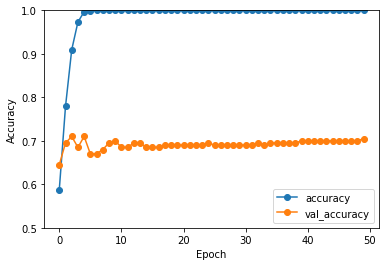

In [11]:
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

Epoch 1/50
80/80 [==============================] - 14s 167ms/step - loss: 11.3949 - accuracy: 0.5335 - val_loss: 0.6518 - val_accuracy: 0.6500
Epoch 2/50
80/80 [==============================] - 14s 170ms/step - loss: 0.5522 - accuracy: 0.7636 - val_loss: 0.6367 - val_accuracy: 0.6700
Epoch 3/50
80/80 [==============================] - 13s 161ms/step - loss: 0.3336 - accuracy: 0.8774 - val_loss: 0.6006 - val_accuracy: 0.7050
Epoch 4/50
80/80 [==============================] - 13s 160ms/step - loss: 0.1406 - accuracy: 0.9645 - val_loss: 0.6746 - val_accuracy: 0.7500
Epoch 5/50
80/80 [==============================] - 13s 166ms/step - loss: 0.0485 - accuracy: 0.9949 - val_loss: 0.9309 - val_accuracy: 0.6850
Epoch 6/50
80/80 [==============================] - 13s 159ms/step - loss: 0.0455 - accuracy: 0.9904 - val_loss: 1.1042 - val_accuracy: 0.7050
Epoch 7/50
80/80 [==============================] - 13s 161ms/step - loss: 0.0100 - accuracy: 0.9999 - val_loss: 1.2338 - val_accuracy: 0.720

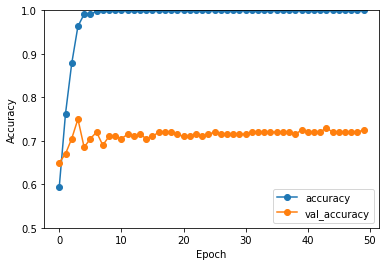

In [28]:
## model with data_generator and dropout of 0.2 .
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3), filters = 64, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
    tf.keras.layers.Dropout(0.2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], )
history = model.fit(train_generator, epochs=50,validation_data=validation_generator)
##
test_loss, test_acc = model.evaluate(test_generator)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

Droput rate has increased the accuracy.  

In [35]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])


predictions = model.predict(test_data['data'] , batch_size = 32)

## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)


In [37]:
print("Classification report :\n{}\n".format(
     classification_report(test_data['target'], test_predicted_labels)))

Classification report :
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       100
           1       0.76      0.83      0.79       100

    accuracy                           0.79       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.79      0.78       200




Check if we can increase the accuracy by using some of the pre-trained models.

In [12]:
base_Net = tf.keras.applications.VGG16(include_top = False, 
                         weights ='imagenet', 
                         input_shape = train_generator.image_shape, 
                         pooling='avg',
                         )

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
80/80 [==============================] - 307s 4s/step - loss: 0.6932 - accuracy: 0.4901 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/50
80/80 [==============================] - 306s 4s/step - loss: 0.6932 - accuracy: 0.4942 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/50
80/80 [==============================] - 306s 4s/step - loss: 0.6932 - accuracy: 0.4870 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/50
80/80 [==============================] - 307s 4s/step - loss: 0.6932 

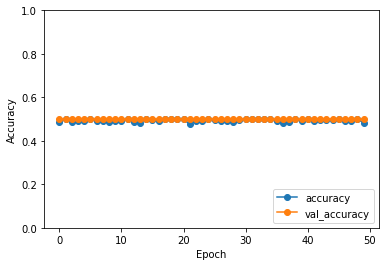

In [23]:
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_Net = tf.keras.models.Sequential()
model_Net.add(base_Net)
model_Net.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

model_Net.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_Net.summary()

# Training the CNN on the Train data and evaluating it on the val data
%time history = model_Net.fit(train_generator, validation_data = validation_generator, epochs = 50)
##
test_loss, test_acc = model_Net.evaluate(test_generator)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


VGG16 model structure is not suitable for the given image dataset.  

Select a lighter model such as MobileNet.

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 3,208,001
Non-trainable params: 21,888
_________________________________________________________________
Epoch 1/50
80/80 [==============================] - 18s 195ms/step - loss: 0.7321 - accuracy: 0.5672 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 2/50
80/80 [==============================] - 14s 171ms/step - loss: 0.6358 - accuracy: 0.6399 - val_loss: 0.6980 - val_accuracy: 0.5000
Epoch 3/50
80/80 [==============================] - 14s 171ms/step - loss: 0.5398 - accuracy: 0.7338 - val_loss: 0.7022 - val_accuracy: 0.5000
Epoch 4/50
80/80 [==============================] - 14s 176ms/step - lo

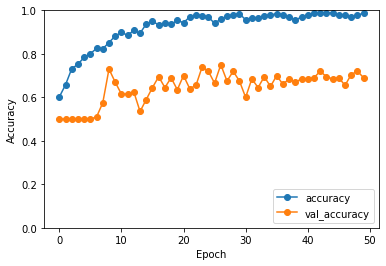

In [22]:
mob_Net = tf.keras.applications.MobileNet(include_top = False, 
                         weights =None, 
                         input_shape = train_generator.image_shape, 
                         pooling='avg',
                         )
#Adding the final layers to the above base models where the actual classification is done in the dense layers
mobile_Net = tf.keras.models.Sequential()
mobile_Net.add(mob_Net)
mobile_Net.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

mobile_Net.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
mobile_Net.summary()

# Training the CNN on the Train data and evaluating it on the val data
%time history = mobile_Net.fit(train_generator, validation_data = validation_generator, epochs = 50)
##
test_loss, test_acc = mobile_Net.evaluate(test_generator)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

Test set image accuracy of MobileNet architecture is  slightly increased to 0.835 as compared to 0.81 with a single convolution layer.     


Try transfer learning with another pre-trained model InceptionResnetV2.  

Found 2538 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense (Dense)                (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 54,277,729
Non-trainable params: 60,544
_________________________________________________________________
Epoch 1/50
80/80 [==============================] - 84s 717ms/step - loss: 0.7329 - accuracy: 0.6579 - val_loss: 1.1269 - val_accuracy: 0.5000
Epoch 2/50
80/80 [==============================] - 50s 622ms/step - loss: 0.5459 - accuracy: 0.7186 - val_loss: 1.1070 - val_accuracy: 0.5000
Epoch 3/50
80/80 [==============================] - 50s 621ms/step - loss: 0.5252 - accurac

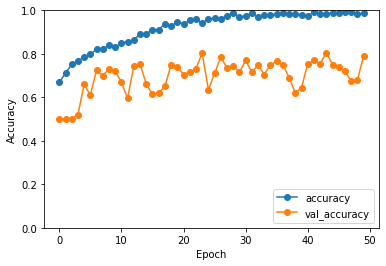

In [9]:
## input image size needs to be in (299,299,3)
train_generator = train_datagen.flow_from_directory(
        train_img_Path,
        target_size=(299, 299),
        batch_size=32,
        class_mode = 'binary',
        shuffle = 'False'
        )
validation_generator = test_datagen.flow_from_directory(
        valid_img_Path,
        target_size=(299, 299),
        batch_size=32,
        class_mode = 'binary',
    shuffle = 'False'
        )
test_generator = test_datagen.flow_from_directory(
        test_img_Path,
        target_size=(299, 299),
        batch_size=32,
        class_mode = 'binary',
    shuffle = 'False'
        )
##
ir_Net = tf.keras.applications.InceptionResNetV2(include_top = False, 
                         weights =None, 
                         input_shape = train_generator.image_shape, 
                         pooling='avg',
                         )
#Adding the final layers to the above base models where the actual classification is done in the dense layers
in_r_Net = tf.keras.models.Sequential()
in_r_Net.add(ir_Net)
in_r_Net.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

in_r_Net.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
in_r_Net.summary()

# Training the CNN on the Train data and evaluating it on the val data
%time history = in_r_Net.fit(train_generator, validation_data = validation_generator, epochs = 50)
##
test_loss, test_acc = in_r_Net.evaluate(test_generator, batch_size = 1)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [15]:
test_data.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [19]:
test_data['target']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [26]:
## check for f1 score for both the classes. 
test_predictions = in_r_Net.predict(test_data['data'], batch_size = 32)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(test_predictions)):
    #pred_label = np.argmax(test_predictions[i])
    if test_predictions[i] < 0.5:
        pred_label = 0
    else:
        pred_label = 1 
    test_predicted_labels.append(pred_label)
##
print("Classification report :\n{}\n".format(
     classification_report(test_data['target'], test_predicted_labels)))

Classification report :
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       100
           1       0.83      0.91      0.87       100

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200




Its'seen that using the pre-trained model architecture , we can increase the accuracy from 0.81 to 0.86 as shown above.  